<img src="./Chicago_image.jpg" style="width:100%; height:auto;">

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay,\
precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score


In [2]:
people_df = pd.read_csv("Data/Traffic_Crashes_-_People_20240824.csv", low_memory=False)
people_df.head(2)

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,M,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


In [3]:
vehicle_df = pd.read_csv("Data/Traffic_Crashes_-_Vehicles_20240824.csv", low_memory=False)
vehicle_df.head(2)

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,1727162,f5943b05f46b8d4148a63b7506a59113eae0cf1075aabc...,12/21/2023 08:57:00 AM,2,PEDESTRIAN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1717556,7b1763088507f77e0e552c009a6bf89a4d6330c7527706...,12/06/2023 03:24:00 PM,1,DRIVER,NaN,1634931.0,NaN,NISSAN,SENTRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Inspecting both datasets and examine the columns

In [4]:
columns_list = people_df.columns.tolist()
print(columns_list)

['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID', 'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE', 'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']


In [5]:
columns_list2 = vehicle_df.columns.tolist()
print(columns_list2)

['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO', 'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE', 'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER', 'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY', 'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I', 'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE', 'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO', 'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO', 'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I', 'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I', 'TRAILER1_WIDTH', 'TRAILER2_WIDTH', 'TRAILER1_LENGTH', 'TRAILER2_LENGTH', 'TOTAL_VEHICLE_LENGTH', 'AXLE_CNT', 'VEH

In [6]:
print(f'Total number of rows in people_df: {people_df.shape}')
print(f'Total number of rows in vehicle_df: {vehicle_df.shape}')

Total number of rows in people_df: (1901033, 29)
Total number of rows in vehicle_df: (1766075, 71)


#### Merge the two datasets

* The VEHICLE_ID column in the people_df corresponds with the CRASH_UNIT_ID from the Vehicle df and we can merge the two datasets and if there are no matching values between `VEHICLE_ID` and `CRASH_UNIT_ID`, those rows will be excluded from the resulting DataFrame 

In [7]:
merged_df = pd.merge(people_df, vehicle_df, left_on='VEHICLE_ID', right_on='CRASH_UNIT_ID')
merged_df.shape

(1739998, 100)

#### Drop columns with large number of nulls

* Drop all rows with nulls exceeding a threshold of 30%

In [8]:
threshold = 0.3
merged_cleaned = merged_df.dropna(thresh=int((1-threshold) * len(merged_df)), axis=1)
cols = merged_cleaned.columns.tolist()
print(cols)

['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID_x', 'VEHICLE_ID_x', 'CRASH_DATE_x', 'CITY', 'STATE', 'SEX', 'AGE', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'BAC_RESULT', 'CRASH_UNIT_ID', 'CRASH_RECORD_ID_y', 'CRASH_DATE_y', 'UNIT_NO', 'UNIT_TYPE', 'VEHICLE_ID_y', 'MAKE', 'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER', 'OCCUPANT_CNT', 'FIRST_CONTACT_POINT']


#### EDA
* Drop columns that are not necessary for our analysis.
* Check the remaining columns for nulls which will be imputed in the data preprocessing.
* Check the datatypes and if there are any inconsistencies

In [11]:
columns_to_drop = ['UNIT_NO', 'OCCUPANT_CNT', 'FIRST_CONTACT_POINT', 'CRASH_RECORD_ID_x', 'BAC_RESULT','PERSON_ID',
                   'CRASH_DATE_y', 'CRASH_RECORD_ID_y', 'VEHICLE_ID_x', 'CRASH_UNIT_ID', 'VEHICLE_ID_y', 'MODEL',
                   'LIC_PLATE_STATE', 'CITY', 'STATE']
final_df = merged_cleaned.drop(columns_to_drop, axis=1)
final_df.shape

(1739998, 19)

In [12]:
final_df.isnull().sum()

PERSON_TYPE                   0
CRASH_DATE_x                  0
SEX                       28692
AGE                      513022
SAFETY_EQUIPMENT            308
AIRBAG_DEPLOYED             310
EJECTION                    313
INJURY_CLASSIFICATION       372
DRIVER_ACTION            359050
DRIVER_VISION            359048
PHYSICAL_CONDITION       359049
UNIT_TYPE                  2260
MAKE                      39691
VEHICLE_YEAR             312175
VEHICLE_DEFECT            39686
VEHICLE_TYPE              39686
VEHICLE_USE               39686
TRAVEL_DIRECTION          39686
MANEUVER                  39686
dtype: int64

In [15]:
final_df.dtypes

PERSON_TYPE               object
CRASH_DATE_x              object
SEX                       object
AGE                      float64
SAFETY_EQUIPMENT          object
AIRBAG_DEPLOYED           object
EJECTION                  object
INJURY_CLASSIFICATION     object
DRIVER_ACTION             object
DRIVER_VISION             object
PHYSICAL_CONDITION        object
UNIT_TYPE                 object
MAKE                      object
VEHICLE_YEAR             float64
VEHICLE_DEFECT            object
VEHICLE_TYPE              object
VEHICLE_USE               object
TRAVEL_DIRECTION          object
MANEUVER                  object
dtype: object

In [23]:
mixed_types = final_df.map(type).nunique() > 1
print(final_df.columns[mixed_types].tolist())

['SEX', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'UNIT_TYPE', 'MAKE', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER']


#### Using regular expressions to convert inconsistent data types
* This will clear spaces and any other punctuations in the dataset hence creating uniformity in the data types.

In [30]:
import re

def clean_string(s):
    if isinstance(s, str):
        s = re.sub(r'[^\w\s\<\>]', '', s)  # Remove punctuation
        s = re.sub(r'\s+', '_', s)     # Replace multiple spaces with a single space
    return s

final_df = final_df.map(clean_string)


## Visualization

#### A graph showing the counts of Injury Classifications

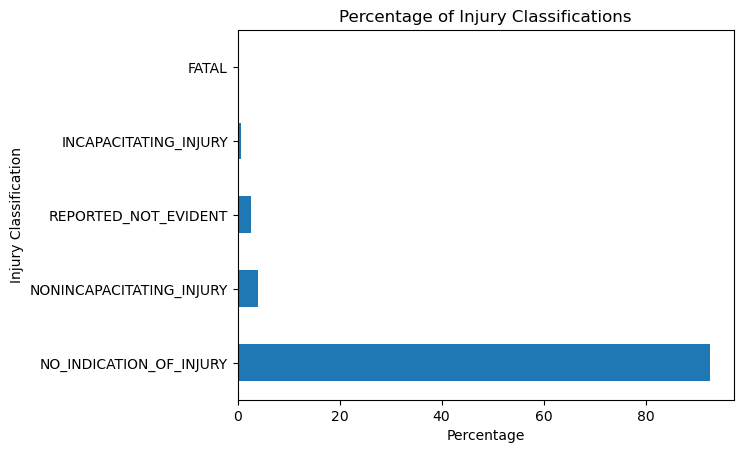

Plot saved as Images/Percentage of Injury Classifications.PNG


In [36]:
counts = final_df['INJURY_CLASSIFICATION'].value_counts(normalize=True)
counts
percentage_counts = counts*100
ax = percentage_counts.plot.barh()


plt.xlabel('Percentage')
plt.ylabel('Injury Classification')
plt.title('Percentage of Injury Classifications')

image_path = 'Images/Percentage of Injury Classifications.PNG'
plt.savefig(image_path, bbox_inches='tight', dpi=300)
plt.show()
print(f"Plot saved as {image_path}")

* From the above graph we can see that the column `INJURY_CLASSIFICATION` has imbalances where most of the data falls on the category `NO_INDICATION_OF_INJURY`

####  A graph showing Count of Males and Females in Each Age Group

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Plot saved as Images/Count of Males and Females in Each Age Group.PNG


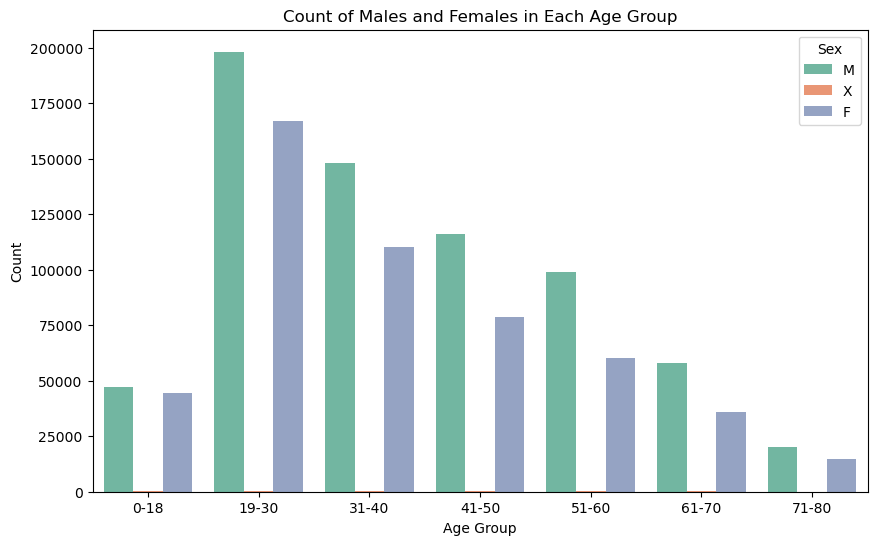

In [39]:
# Define age bins and labels
age_bins = [0, 18, 30, 40, 50, 60, 70, 80]
age_labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80']

# Bin the ages
final_df['Age Group'] = pd.cut(final_df['AGE'], bins=age_bins, labels=age_labels)

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(x=final_df['Age Group'], hue='SEX', data=merged_df, palette='Set2')

# Adding labels and title
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Count of Males and Females in Each Age Group')
plt.legend(title='Sex')
image_path = 'Images/Count of Males and Females in Each Age Group.PNG'
plt.savefig(image_path, bbox_inches='tight', dpi=300)
print(f"Plot saved as {image_path}")
plt.show()


* From the above graph, the individuals both `males and females` between age `19-30` had the most incidences of car crashes.
* `Males` in this age group had the highest occurrences with over 180000 crashes while over 170000 `Females` in the same age_group of `19-30` had a crash.

#### Plotting the Count of Injury Classifications by Sex

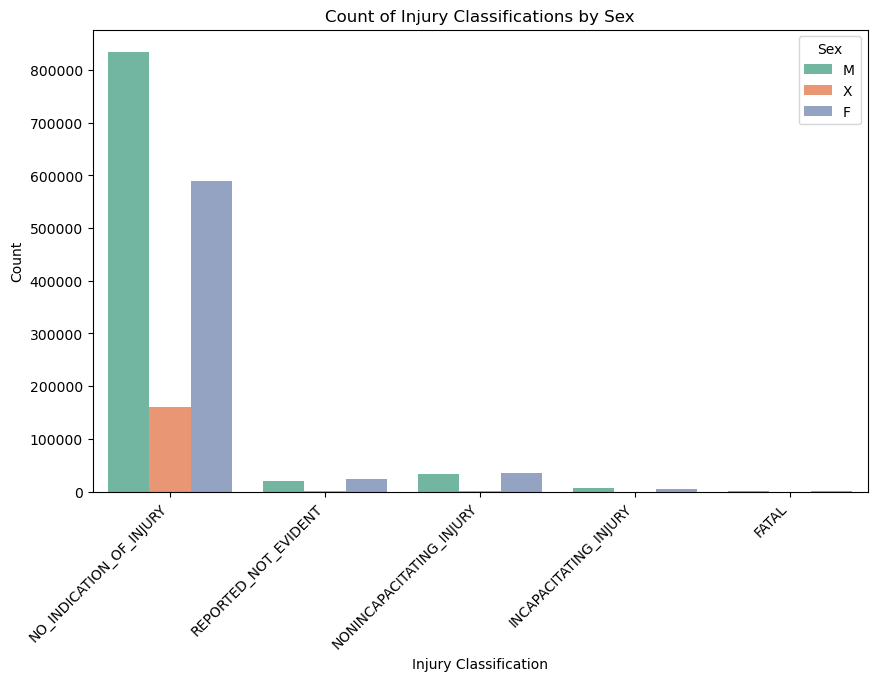

Plot saved as Images/Count of Injury Classifications by Sex.PNG


In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(x='INJURY_CLASSIFICATION', hue='SEX', data=final_df, palette='Set2')

# Adding labels and title
plt.xlabel('Injury Classification')
plt.ylabel('Count')
plt.title('Count of Injury Classifications by Sex')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Sex')
image_path = 'Images/Count of Injury Classifications by Sex.PNG'
plt.savefig(image_path, bbox_inches='tight', dpi=300)
plt.show()
print(f"Plot saved as {image_path}")

* This graph shows the imbalance in the classifications in the dataset with the class `NO_INDICATION_OF_INJURY` getting a large sample.
* From the graph `MALES` have high occurrences in all the five classes followed by `FEMALES`.

#### A Piechart showing percentages of the gender distribution. 

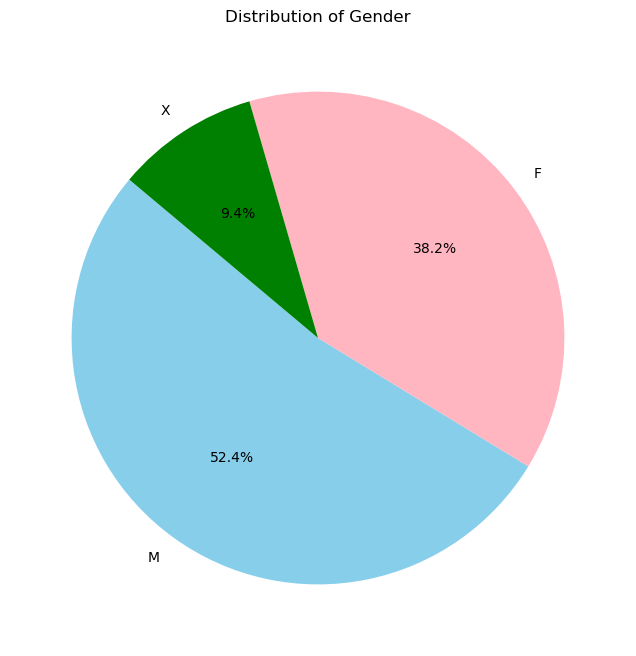

Plot saved as Images/Distribution of Gender.PNG


In [41]:
sex_counts = final_df['SEX'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightpink', 'green'])

# Adding a title
plt.title('Distribution of Gender')
image_path = 'Images/Distribution of Gender.PNG'
plt.savefig(image_path, bbox_inches='tight', dpi=300)
plt.show()
print(f"Plot saved as {image_path}")

* The datasets had a larger sample of males with a leading percentage of `52.4%` which is more than half of the dataset.
* The females had a `38.2%` while X a non-binary or gender non-conforming identity had `9.4%`

#### A graph showing Percentage of Physical Condition Classifications

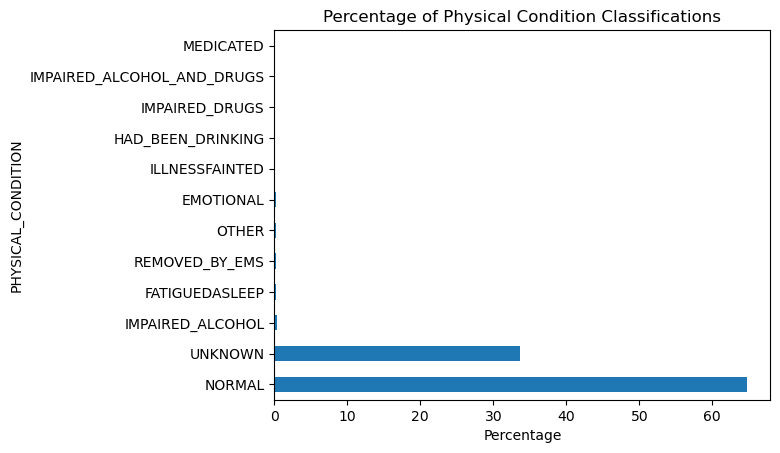

Plot saved as Images/Percentage of Physical Condition Classifications.PNG


In [42]:
percentages = final_df['PHYSICAL_CONDITION'].value_counts(normalize=True)*100
ax = percentages.plot.barh()


plt.xlabel('Percentage')
plt.ylabel('PHYSICAL_CONDITION')
plt.title('Percentage of Physical Condition Classifications')

image_path = 'Images/Percentage of Physical Condition Classifications.PNG'
plt.savefig(image_path, bbox_inches='tight', dpi=300)
plt.show()
print(f"Plot saved as {image_path}")

* The `NORMAL` classification had the highest percentage with over `65%` which shows that more than `65%` crashes people involved were in normal conditions.

#### Examining the columns.
* Let's check which columns are good for our model training.
* Drop the columns that are redudant to reduce the dataset.

In [43]:
columns_list = final_df.columns.tolist()
print(columns_list)

['PERSON_TYPE', 'CRASH_DATE_x', 'SEX', 'AGE', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'UNIT_TYPE', 'MAKE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER', 'Age Group']


In [45]:
columns_to_drop = ['MAKE', 'CRASH_DATE_x', 'VEHICLE_YEAR', 'Age Group',]
modelling_df = final_df.drop(columns_to_drop, axis=1)
modelling_df.shape

(1739998, 16)

#### Check for Numerical columns and categorical columns
* Define a `function` to `grab_numeric` and `grab_categorical` columns from a dataframe.
* This helps in understanding the dataset before modelling and cleaning.
* The dataframe used for modelling has been named `modelling_df`.
* This is the dataframe we are passing to the Machine learning models.

In [46]:
def grab_numeric(df):
    """Select numeric columns from the DataFrame."""
    return df.select_dtypes(include=['float64', 'int']).columns

def grab_categorical(df):
    """Select categorical columns from the DataFrame."""
    return df.select_dtypes(include=['object']).columns

In [47]:
numeric_feature_names = grab_numeric(modelling_df)
numeric_feature_names


Index(['AGE'], dtype='object')

In [48]:
categorical_feature_names = grab_categorical(modelling_df).drop('INJURY_CLASSIFICATION')
categorical_feature_names

Index(['PERSON_TYPE', 'SEX', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION',
       'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'UNIT_TYPE',
       'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION',
       'MANEUVER'],
      dtype='object')

#### The `modeling_df`
* The modelling_df has only one numerical column which is `AGE`.
* The categorical columns are: `'PERSON_TYPE', 'SEX', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION',
       'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'UNIT_TYPE',
       'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION',
       'MANEUVER'`

In [49]:
modelling_df.head()

,PERSON_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,UNIT_TYPE,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER
0,DRIVER,M,25.0,NONE_PRESENT,DEPLOYMENT_UNKNOWN,NONE,NO_INDICATION_OF_INJURY,UNKNOWN,UNKNOWN,UNKNOWN,DRIVER,NONE,PASSENGER,PERSONAL,N,TURNING_RIGHT
1,DRIVER,M,37.0,SAFETY_BELT_USED,DID_NOT_DEPLOY,NONE,NO_INDICATION_OF_INJURY,NONE,NOT_OBSCURED,NORMAL,DRIVER,NONE,PASSENGER,PERSONAL,E,STRAIGHT_AHEAD
2,DRIVER,X,NaN,USAGE_UNKNOWN,DEPLOYMENT_UNKNOWN,NONE,NO_INDICATION_OF_INJURY,IMPROPER_BACKING,UNKNOWN,UNKNOWN,PARKED,NONE,PASSENGER,NOT_IN_USE,S,PARKED
3,DRIVER,X,NaN,USAGE_UNKNOWN,DEPLOYMENT_UNKNOWN,UNKNOWN,NO_INDICATION_OF_INJURY,UNKNOWN,UNKNOWN,UNKNOWN,DRIVER,NONE,PASSENGER,TAXIFOR_HIRE,N,OTHER
4,DRIVER,X,NaN,USAGE_UNKNOWN,DEPLOYMENT_UNKNOWN,UNKNOWN,NO_INDICATION_OF_INJURY,UNKNOWN,UNKNOWN,UNKNOWN,DRIVER,NONE,PASSENGER,PERSONAL,W,STRAIGHT_AHEAD


## Modelling

* Let's split the data from the `modelling_df` into `train` and `test` sets with a `test_size` of `20%` and `random_state=42`.
* Our `Target` column is `INJURY_CLASSIFICATION` and we will drop it when selecting our `Feature variables` to avoid `data leakage` when training the models.
* We will use `train_test_split` from `scikit-learn` to split the data into training and test sets.

In [50]:
X = modelling_df.drop(columns=["INJURY_CLASSIFICATION"], axis=1)
y = modelling_df["INJURY_CLASSIFICATION"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## Data Preprocessing

#### Check and impute the Missing Values
* We will begin with imputing the nullvalues since the `modelling_df` had missing values
* Let's begin with the target variable y.
* Check both `y_train` and `y_test` for `null` values

In [51]:
y_train.isna().sum()

297

In [52]:
y_test.isna().sum()

75

In [53]:
y_train.shape

(1391998,)

#### Dealing with null values.
* We have seen that the train and test set have null values.
* Imputing these values can cause `data leakage` because the goal is to use `y_test` as an `untouched`, `unbiased sample` to `evaluate` the model's `generalization` to `new data`.
* Therefore `imputation` in the `y_train` and the `y_test` is highly discouraged.
* From the dataset we can see there are few `missing values`and `dropping the rows` would not have a big impact on our dataset since we have `1391998` rows in our dataset.
* However, the `dropped rows` from our `target variable` should be `dropped` from our `features` to maintain alignment between the `features` and the `target variable` to avoid `incorrect predictions`.  

#### Identifying null indices.
* Let's identify the `null indices` from our `target` variable and `align` them with `corresponding indices` from `feature variables`.
* Then `drop nulls` from both the `target` variable and the `feature` variables.


In [54]:
y_train_null_indices = y_train[y_train.isnull()].index
X_train = X_train.drop(y_train_null_indices, axis=0)
y_train = y_train.drop(y_train_null_indices, axis=0)

In [55]:
y_test_null_indices = y_test[y_test.isnull()].index
X_test = X_test.drop(y_test_null_indices, axis=0)
y_test = y_test.drop(y_test_null_indices, axis=0)

* Let's check for nulls and the shape of our target.

In [56]:
y_train.isna().sum()

0

In [57]:
y_test.isna().sum()

0

In [58]:
y_train.shape

(1391701,)

* We have dropped over 200 columns from the target variable and it should correspond to our `feature variables`.

In [63]:
print(f'{X_train.shape}: Perfect!!!!!!!!')

(1391701, 15): Perfect!!!!!!!!


#### Imputing the `Feature` variables
* Instantiate a MissingIndicator and fit it to the train data.

In [64]:
from sklearn.impute import MissingIndicator
indicator_demo = MissingIndicator()

indicator_demo.fit(X_train)

indicator_demo.features_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [67]:
X_train.isna().sum()

PERSON_TYPE                0
SEX                    22699
AGE                   410138
SAFETY_EQUIPMENT          15
AIRBAG_DEPLOYED           19
EJECTION                  21
DRIVER_ACTION         287272
DRIVER_VISION         287271
PHYSICAL_CONDITION    287272
UNIT_TYPE               1811
VEHICLE_DEFECT         31651
VEHICLE_TYPE           31651
VEHICLE_USE            31651
TRAVEL_DIRECTION       31651
MANEUVER               31651
dtype: int64

In [68]:
indicator_demo.transform(X_train)[:, 1:15]

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [69]:
X_train.iloc[:5, [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]]

,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,UNIT_TYPE,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER
342724,M,31.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,UNKNOWN,NOT_OBSCURED,NORMAL,PEDESTRIAN,NaN,NaN,NaN,NaN,NaN
1300050,M,44.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,UNKNOWN,UNKNOWN,UNKNOWN,DRIVER,UNKNOWN,PASSENGER,PERSONAL,E,STRAIGHT_AHEAD
1317000,M,53.0,USAGE_UNKNOWN,DEPLOYMENT_UNKNOWN,NONE,OTHER,UNKNOWN,UNKNOWN,DRIVER,NONE,SPORT_UTILITY_VEHICLE_SUV,PERSONAL,S,STRAIGHT_AHEAD
1699391,NaN,NaN,NONE_PRESENT,DEPLOYMENT_UNKNOWN,UNKNOWN,NaN,NaN,NaN,PEDESTRIAN,NaN,NaN,NaN,NaN,NaN
1400401,F,25.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,NONE,NOT_OBSCURED,NORMAL,DRIVER,NONE,PASSENGER,PERSONAL,S,OTHER


In [70]:
indicator = MissingIndicator(features="all")
indicator.fit(X_train)

MissingIndicator(features='all')


* Create a Helper function for transforming features
    
*  For every feature in X, create another feature indicating whether that feature
    is missing. (This doubles the number of columns in X.)
    
    
*  Create a 2D array of True and False values indicating whether a given feature
    is missing for that row

In [71]:
def add_missing_indicator_columns(X, indicator):
   
    missing_array_bool = indicator.transform(X)
    
    # transform into 1 and 0 for modeling
    missing_array_int = missing_array_bool.astype(int)
    
    # helpful for readability but not needed for modeling
    missing_column_names = [col + "_missing" for col in X.columns]
    
    # convert to df so it we can concat with X
    missing_df = pd.DataFrame(missing_array_int, columns=missing_column_names, index=X.index)
    
    return pd.concat([X, missing_df], axis=1)

In [72]:
X_train = add_missing_indicator_columns(X=X_train, indicator=indicator)

In [73]:
X_train.head()

,PERSON_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,UNIT_TYPE,...,EJECTION_missing,DRIVER_ACTION_missing,DRIVER_VISION_missing,PHYSICAL_CONDITION_missing,UNIT_TYPE_missing,VEHICLE_DEFECT_missing,VEHICLE_TYPE_missing,VEHICLE_USE_missing,TRAVEL_DIRECTION_missing,MANEUVER_missing
342724,DRIVER,M,31.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,UNKNOWN,NOT_OBSCURED,NORMAL,PEDESTRIAN,...,0,0,0,0,0,1,1,1,1,1
1300050,DRIVER,M,44.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,UNKNOWN,UNKNOWN,UNKNOWN,DRIVER,...,0,0,0,0,0,0,0,0,0,0
1317000,DRIVER,M,53.0,USAGE_UNKNOWN,DEPLOYMENT_UNKNOWN,NONE,OTHER,UNKNOWN,UNKNOWN,DRIVER,...,0,0,0,0,0,0,0,0,0,0
1699391,PASSENGER,NaN,NaN,NONE_PRESENT,DEPLOYMENT_UNKNOWN,UNKNOWN,NaN,NaN,NaN,PEDESTRIAN,...,0,1,1,1,0,1,1,1,1,1
1400401,DRIVER,F,25.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,NONE,NOT_OBSCURED,NORMAL,DRIVER,...,0,0,0,0,0,0,0,0,0,0


In [74]:
numeric_feature_names = ["AGE"]
categorical_feature_names = ['PERSON_TYPE', 'SEX', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION',
       'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'UNIT_TYPE',
       'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION',
       'MANEUVER']

X_train_numeric = X_train[numeric_feature_names]
X_train_categorical = X_train[categorical_feature_names]

* From scikit learn library import SimpleImputer
* Fit the imputer to the X_train

In [75]:
from sklearn.impute import SimpleImputer
numeric_imputer = SimpleImputer()
numeric_imputer.fit(X_train_numeric)

SimpleImputer()

In [76]:
categorical_imputer = SimpleImputer(strategy="most_frequent")
categorical_imputer.fit(X_train_categorical)

SimpleImputer(strategy='most_frequent')

* Given a DataFrame and an imputer, use the imputer to fill in all missing values in the DataFrame

In [77]:
def impute_missing_values(X, imputer):
    
    imputed_array = imputer.transform(X)
    imputed_df = pd.DataFrame(imputed_array, columns=X.columns, index=X.index)
    return imputed_df

In [78]:
X_train_numeric = impute_missing_values(X_train_numeric, numeric_imputer)
X_train_categorical = impute_missing_values(X_train_categorical, categorical_imputer)

In [79]:
X_train_imputed = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train_imputed.isna().sum()

AGE                   0
PERSON_TYPE           0
SEX                   0
SAFETY_EQUIPMENT      0
AIRBAG_DEPLOYED       0
EJECTION              0
DRIVER_ACTION         0
DRIVER_VISION         0
PHYSICAL_CONDITION    0
UNIT_TYPE             0
VEHICLE_DEFECT        0
VEHICLE_TYPE          0
VEHICLE_USE           0
TRAVEL_DIRECTION      0
MANEUVER              0
dtype: int64

In [80]:
X_train = X_train.drop(numeric_feature_names + categorical_feature_names, axis=1)
X_train = pd.concat([X_train_imputed, X_train], axis=1)

In [81]:
X_train.isna().sum()

AGE                           0
PERSON_TYPE                   0
SEX                           0
SAFETY_EQUIPMENT              0
AIRBAG_DEPLOYED               0
EJECTION                      0
DRIVER_ACTION                 0
DRIVER_VISION                 0
PHYSICAL_CONDITION            0
UNIT_TYPE                     0
VEHICLE_DEFECT                0
VEHICLE_TYPE                  0
VEHICLE_USE                   0
TRAVEL_DIRECTION              0
MANEUVER                      0
PERSON_TYPE_missing           0
SEX_missing                   0
AGE_missing                   0
SAFETY_EQUIPMENT_missing      0
AIRBAG_DEPLOYED_missing       0
EJECTION_missing              0
DRIVER_ACTION_missing         0
DRIVER_VISION_missing         0
PHYSICAL_CONDITION_missing    0
UNIT_TYPE_missing             0
VEHICLE_DEFECT_missing        0
VEHICLE_TYPE_missing          0
VEHICLE_USE_missing           0
TRAVEL_DIRECTION_missing      0
MANEUVER_missing              0
dtype: int64

## OneHotEncoding

#### Helper function for transforming training data.  
* It takes in the full X dataframe and feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe with that feature transformed into multiple columns of 1s and 0s
* We will use encoder = OneHotEncoder(sparse_output = True)
* Make a one-hot encoder and fit it to the training data.
* Then call helper function that actually encodes the feature and concats it

In [82]:
def encode_and_concat_feature_train(X_train, feature_name):
    
    
    ohe = OneHotEncoder(sparse_output = True, categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
   
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

* We create a helper function for transforming a feature into multiple columns of 1s and 0s. Used
in both training and testing steps.  Takes in the full X dataframe, feature name, and encoder, 
and returns the dataframe with that feature transformed into multiple columns of 1s and 0s
* create new one-hot encoded df based on the feature

In [83]:
def encode_and_concat_feature(X, feature_name, ohe):
   
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [84]:
encoders = {}

for categorical_feature in categorical_feature_names:
    ohe, X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe

In [85]:
X_train.shape

(1391701, 208)

* After encoding our X_train, there is a significant increase of the columns from 15 to 208
  

#### Label encoding for our target variable
* We will use `LabelEncoder` from scikit-learn libraries to encode our `target` variable.
* Since this is a Multiclassification model, label encoding is suitable for the `target` variable because it maps each `category` to a `unique integer`, which the model can use `directly` to predict `class labels`

In [172]:
from sklearn.preprocessing import LabelEncoder
array = np.array(y_train)
y_train = pd.Series(array)

In [173]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train)

In [174]:
y_train.shape

(1391998,)

In [175]:
model1 = DecisionTreeClassifier(max_depth = 5)
model1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [130]:
model1.score(X_train, y_train)

0.9270185733025479

In [176]:
cv_results = cross_val_score(model1, X_train, y_train, cv=5)
cv_results

array([0.92702586, 0.92697198, 0.92706537, 0.92696094, 0.92700405])

In [ ]:
pred = model1.predict(X_test)

In [199]:
# cm = confusion_matrix(y_test, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix - Decision Tree Classifier')
# plt.show()

In [178]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)


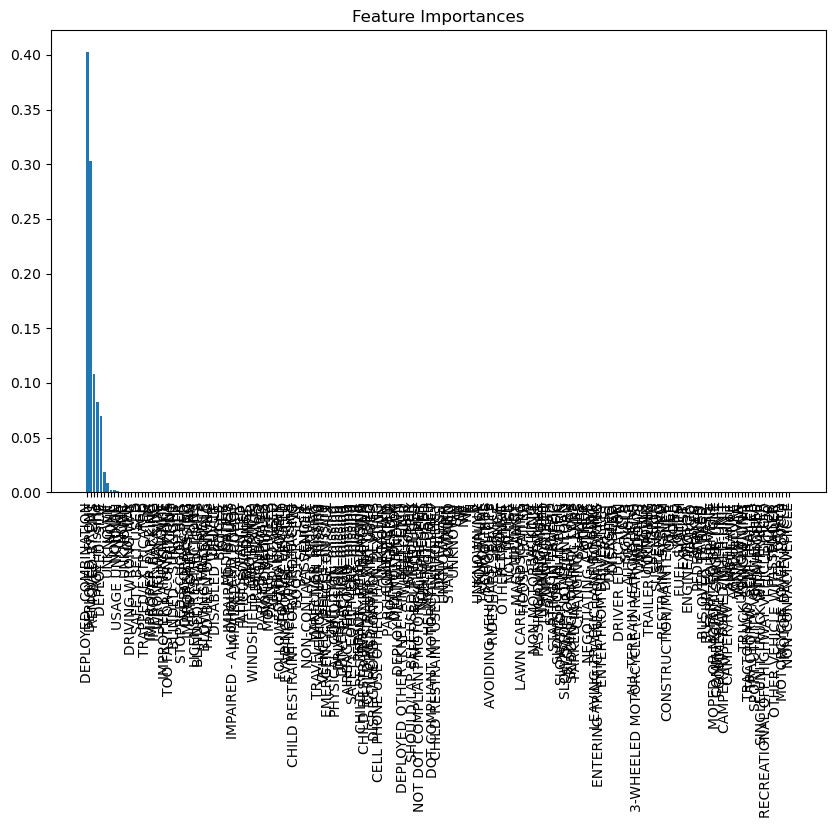

In [180]:
important_features=model1.feature_importances_
indices = np.argsort(important_features)[::-1]
# Plot
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), important_features[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

#### Transform X_test

In [181]:
X_test_no_transformation = X_test.copy()

In [182]:
X_test_missing = add_missing_indicator_columns(X_test_no_transformation, indicator)

In [183]:
X_test_numeric = X_test_missing[numeric_feature_names]
X_test_categorical = X_test_missing[categorical_feature_names]

In [184]:
# Impute all Missing Values
X_test_numeric = impute_missing_values(X_test_numeric, numeric_imputer)
X_test_categorical = impute_missing_values(X_test_categorical, categorical_imputer)
X_test_imputed = pd.concat([X_test_numeric, X_test_categorical], axis=1)


In [185]:
X_test_new = X_test_missing.drop(numeric_feature_names + categorical_feature_names, axis=1)
X_test_final= pd.concat([X_test_imputed, X_test_new], axis=1)

In [186]:
for categorical_feature in categorical_feature_names:
    X_test_final = encode_and_concat_feature(X_test_final,
                                       categorical_feature, encoders[categorical_feature])

In [188]:
X_test_final = X_test_final.reindex(columns=X_train.columns, fill_value=0)

In [189]:
threshold = 0.01
top_indices = np.where(important_features > threshold)[0]
X_train_reduced = X_train.iloc[:, top_indices]
X_test_reduced = X_test_final.iloc[:, top_indices]

In [190]:
model2 = DecisionTreeClassifier(max_depth = 5)
model2.fit(X_train_reduced, y_train)

DecisionTreeClassifier(max_depth=5)

In [ ]:
# 

In [191]:
model_after_feature_selection_results = ModelWithCV(
                            model2,
                            DecisionTreeClassifier,
                            X_train_reduced,
                            y_train

)                   

In [192]:
model_results=model_after_feature_selection_results
model_results.print_cv_summary()

CV Results for `<class 'sklearn.tree._classes.DecisionTreeClassifier'>` model:
            0.92701 ± 0.00007 accuracy
        


In [193]:
X_train_reduced.shape

(1391998, 6)

In [196]:
# cm = confusion_matrix(y_test, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix - Decision Tree Classifier')
# plt.show()

#### Reducing the features to 6 still maintained the accuracy score

In [99]:
# y_pred = model3.predict(X_test)
# confusion_matrix=confusion_matrix(y_test_resampled, y_pred_resampled)

### Logistic Regression Model

In [204]:
simple_logreg_model = LogisticRegression(random_state = 42, penalty = 'l2', solver='saga', max_iter = 1000)
simple_logreg_model.fit(X_train_reduced, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='saga')

In [205]:
simple_logreg_model.score(X_train_reduced, y_train)

0.927021446869895

In [207]:
Scaler = StandardScaler()
Scaler.fit(X_train_reduced)

StandardScaler()

In [208]:
def scale_values(X, scaler):
    scaled_array = scaler.transform(X)
    scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)
    return scaled_df

In [210]:
X_train = scale_values(X_train_reduced, Scaler)

In [213]:
X_train.head()

,AGE_missing,F,"DEPLOYED, COMBINATION","DEPLOYED, FRONT","DEPLOYED, SIDE",REMOVED BY EMS
342724,-0.646633,-0.776340,-0.162801,-0.181601,-0.096557,-0.045612
1300050,-0.646633,-0.776340,-0.162801,-0.181601,-0.096557,-0.045612
1317000,-0.646633,-0.776340,-0.162801,-0.181601,-0.096557,-0.045612
1699391,1.546472,-0.776340,-0.162801,-0.181601,-0.096557,-0.045612
1400401,-0.646633,1.288095,-0.162801,-0.181601,-0.096557,-0.045612


In [215]:
logreg_model = LogisticRegression(random_state=2021)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=2021)

In [216]:
model_after_scaling_results = ModelWithCV(
                            logreg_model,
                            LogisticRegression,
                            X_train,
                            y_train

)   

In [217]:
model_results=model_after_feature_selection_results
model_results.print_cv_summary()

CV Results for `<class 'sklearn.tree._classes.DecisionTreeClassifier'>` model:
            0.92701 ± 0.00007 accuracy
        
